# Spam Classification Evaluation

This practical sessions was produced using [Jupyter](http://jupyter.org). If you are used to it, you can [download the corresponding notebook code from here](TP-SpamClassification.ipynb). If not, no problem at all, this is not mandatory: simply proceed as usual in your favorite Python environment.

## Introduction

The aim of this practical session is to get yourself acquainted with the ill-balanced nature of NLP classification tasks and to get some exposure to the [scikit-learn](https://scikit-learn.org/stable/index.html) and [spaCy](https://spacy.io/) packages.

A great example of a highly-biased task is **spam classification**. The goal of the task is to classify whether a given piece of text (e.g., email, sms message) is spam or not. Since there are only 2 classes (spam or not), we call such tasks **binary classification**.

In reality, the amount of examples we have of non-spam emails is much larger than the ones that are spam. Therefore, we need proper evaluation techniques to deal with such a class imbalance.

*Fun fact: if a piece of text is not spam, it's popularly called ham!*

### Content Warning: this exercise's data will contain explicit words.

## Setting up your environment

While you can downlaod the following packages with `pip` to your computer directly, we recommend **(but not require)** you to use a [virtual environment](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/) to not mess up the package versions for different project. If you'd like to, here is a [quick tutorial](https://docs.google.com/document/d/1D8TapyWrfyWijfrGq5BtYfrAoWmSmgcP-Gx3i2MXWvo/edit) on virtual environments that you can checkout with an EPFL email. 

First make sure you have (a virtual environment (e.g., [venv, virtualenv](https://docs.python.org/3/library/venv.html), [conda](https://docs.conda.io/en/latest/miniconda.html)), and that the environment has) a Python version >= 3.6, per [spaCy package requirements](https://spacy.io/usage). If you are using the a Jupyter Notebook, make sure the interpreter points to the correct `python` executable.

Then install the following packages:

```
pip install -U ipykernel
pip install -U pip setuptools wheel
pip install -U pandas
pip install -U matplotlib
pip install -U scikit-learn
pip install -U seaborn
pip install -U spacy
pip install -U classy-classification

python -m spacy download en_core_web_sm
```

Next, import the necessary packages:

*Note: if this part of the code hangs, simply restart your kernel and rerun, sometimes importing packages multiple times can create a problem*

In [1]:
# Importing necessary packages:
import spacy
import classy_classification
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

# Setting the seed:
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)

# Setting print options for readability:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now you are ready to start the exercises!

## 1) Brief Data Analysis & Processing

To evaluate the spam task, we will use an annotated English sms corpus from  Kaggle. You can download the data [here](https://coling.epfl.ch/TP/spam.csv). Run the following 2 blocks of code to see what the data looks like:

In [2]:
df = pd.read_csv("spam.csv", header=0, names=['label','sms'], usecols=[0,1])
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
df.tail()

,label,sms
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the ï¿½750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will ï¿½_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free
5571,ham,Rofl. Its true to its name


As you can see there are 2 types of classes: "ham" & "spam". Let's take a look at their distribution:

In [4]:
print("Label counts are:")
print(df.label.value_counts())

print("______________________")
print("Label percentages are:")
print(df.label.value_counts(normalize=True))

Label counts are:
ham     4825
spam     747
Name: label, dtype: int64
______________________
Label percentages are:
ham     0.865937
spam    0.134063
Name: label, dtype: float64


**Q: How is this dataset's label distribution imbalanced? Which datapoints are more common?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
The labels are heavily biased on the ham side. We have very little spam datapoints.
```

Let's do some minor data processing. We map the labels {"ham" $\implies$ 0} and {"spam" $\implies$ 1} as our goal is to identify spam messages.

In [5]:
df['label'] = df['label'].replace(to_replace={'ham': 0, 'spam': 1})
df.head()

,label,sms
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


Then, to make sure that we don't overfit our models to the data, we split the data into train and test sets. We use the very convenient [**train_test_split**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from [scikit-learn](https://scikit-learn.org/stable/index.html). The *test_size* parameter allows us to choose what percentage of the data should be in the test set. $x$ is the sms message, while $y$ is the corresponding label to the sms.

Remember, when you are prototyping a model, never use the test data. The goal of the test data is to simulate an independently sampled dataset, that cannot be seen during training and model designing. Extracted statistics should come from the training set only.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['sms'].values, df['label'].values, test_size=0.2, random_state=seed)

print("Spam amount in train set: {} out of {} datapoints".format((y_train == 1).sum(), len(y_train)))
print("Spam percentage in train set: {}%".format(round((y_train == 1).sum() / float(len(y_train)) * 100, 4)))

print("Size of train set is: ", len(y_train))
print("Size of test set is: ", len(y_test))

Spam amount in train set: 597 out of 4457 datapoints
Spam percentage in train set: 13.3947%
Size of train set is:  4457
Size of test set is:  1115


## 2) Simple & Random Classifiers

### 2.1) Accuracy

Our first task is to evaluate simple classifiers to see how well they do on the spam classification task. Note that while there is a text input, none of these classifiers actually care about the content of the string. Remember that a **prior** in probability is one's belief about a quantity given some past evidence.

1. **rand_binom_uniform_classifier:** The first model uniformly randomly classifies the label for a given piece of text, meaning the prior is $p=0.5$.

2. **rand_binom_biased_classifier:** The second model binomally samples a label, *you should chose which prior $p$ you think makes the most sense!*

3. **always_false_classifier:** The third model returns always false, basically assuming that no text can ever be spam.

Don't forget to change the value **prior_p** $=0.5$! Chose the value informatively! Think which statistics can help you with this.

In [7]:
##############################
# TODO: write a prior you think that makes the most sense in the next line for the rand_binom_biased_classifier:
prior_p = 0.5 # <-------- CHANGE THIS VALUE!
##############################

def rand_binom_uniform_classifier(text):
    """
    Unfiormly randomly picks a binary label.
    Returns ints 0 or 1.
    """
    return np.random.binomial(n=1, p=0.5)

def rand_binom_biased_classifier(text):
    """
    Randomly picks a binary label according to a prior_p.
    Returns ints 0 or 1.
    """
    return np.random.binomial(n=1, p=prior_p)

def always_false_classifier(text):
    """
    Always returns int 0.
    """
    return 0

def predict(model, dataset):
    """
    Applies model prediction on every sentence.
    """
    return [model(text) for text in dataset]

Now we are going to use the [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) metric provided by scikit-learn:

In [8]:
rand_binom_uniform_preds = predict(rand_binom_uniform_classifier, x_test)
rand_binom_biased_preds = predict(rand_binom_biased_classifier, x_test)
always_false_preds = predict(always_false_classifier, x_test)

for model_name, model in [
        ("Rand Uniform", rand_binom_uniform_classifier), 
        ("Rand Binom p={}".format(prior_p), rand_binom_biased_classifier), 
        ("Always False", always_false_classifier)]:
    test_preds = predict(model, x_test)
    test_accuracy = accuracy_score(y_test, test_preds) # NOTE: here we pass the gold labels and the predicted labels to calculate how well our model is doing
    print("Model: {} || Accuracy: {}%".format(model_name, round(test_accuracy * 100, 4)))

Model: Rand Uniform || Accuracy: 50.4036%
Model: Rand Binom p=0.5 || Accuracy: 51.1211%
Model: Always False || Accuracy: 86.5471%


Wow! Looks like the "Always False" classifier is amazing at this task, even better than randomly choosing. Over 85% sounds like a pretty good result. Can we call it quits, and go home now? Not so fast... Answer the following questions.

**Q: Which prior did you choose and why do you think it fits the problem? If you chose your prior informatively, the Rand Binom classifier should be better than the Rand Uniform classifier. Why is the biased random classifier doing better than the uniform one?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
The prior_p that should've been picked is around 13%, depending on what statistics we get from the training data. It fits the problem as most of the time the random classifier should guess that the message is not spam. If the model guesses spam 50% of the time, it will get it wrong more often.
```

**Q: How would using testing data to design the model be "bad practice"? Give an example.**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
By using test statistics, we can make our test metrics (such as accuracy) look better than what they actually are. An example would be, if we have designed a model ourselves, and use test statistics to adjust our model's parameters, this can be a form of cheating scientific results.
```

**Q: Why is the accuracy score not the correct metric to use in this task? Which classifier is a good example of this? What other metrics can be used and why would they be a better fit for this task?** 

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
For uneven classes, accuracy cannot distinguish a well performing system.  
We can see this from the "Always False" classifier, that doesn't help us solve anything (nothing spam gets filtered out, the task isn't even remotely handled).
A better metric can be something that measures precision and/or recall.
```

### 2.2) Precision, Recall, F1-score & Friends

Now that you have convinced yourself that accuracy is not the sole metric we should be using. 
For the other possible scores we let you explore the following metrics conveniently provided by scikit-learn:

- [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
- [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
- [f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
- [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) - while this is not a metric, it allows to visualize the true positives, true negatives, false positives, and false negatives (TP, TN, FP, FN)

Note that some of these function also has a *zero_division* parameter as the denominator of these metrics can be validly 0. In that case the default is to also output 0, but a warning may be raised. Feel free to ignore the warning.

---

TIP: Can you not remember what precision and recall is? Remember it with the start of the word:

- Precision: PREcision is TP divided by **PREdicted** positive: 
    > $ \frac{TP}{TP+FP}$

- Recall: REcAll is TP divided by **REAl** positive: TP/(TP+FN)
    > $ \frac{TP}{TP+FN}$

source: [stats.stackexchange](https://stats.stackexchange.com/questions/122225/what-is-the-best-way-to-remember-the-difference-between-sensitivity-specificity)

---

Model: Rand Uniform
	|| Accuracy: 0.5219730941704036% 
	|| Precision: 0.14990859232175502% 
	|| Recall: 0.5466666666666666% 
	|| F1: 0.2352941176470588% 


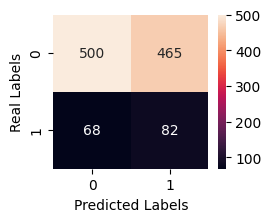

Model: Rand Binom p=0.5
	|| Accuracy: 0.5103139013452915% 
	|| Precision: 0.14259927797833935% 
	|| Recall: 0.5266666666666666% 
	|| F1: 0.22443181818181818% 


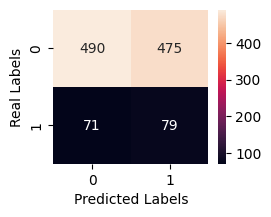

Model: Always False
	|| Accuracy: 0.8654708520179372% 
	|| Precision: 0.0% 
	|| Recall: 0.0% 
	|| F1: 0.0% 


/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


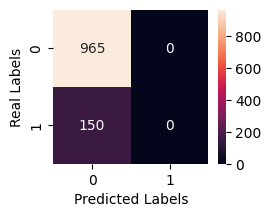

In [9]:
for model_name, model in [
        ("Rand Uniform", rand_binom_uniform_classifier), 
        ("Rand Binom p={}".format(prior_p), rand_binom_biased_classifier), 
        ("Always False", always_false_classifier)]:
    
    test_preds = predict(model, x_test)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    cf_train_matrix = confusion_matrix(y_test, test_preds)

    # print("________________________________________________________________")
    print("Model: {}".format(model_name))
    print("\t|| Accuracy: {}% ".format(test_accuracy))
    print("\t|| Precision: {}% ".format(test_precision))
    print("\t|| Recall: {}% ".format(test_recall))
    print("\t|| F1: {}% ".format(test_f1))

    plt.figure(figsize=(2.5,2))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d')
    plt.xlabel("Predicted Labels")
    plt.ylabel("Real Labels")
    plt.show()

**Q: What do precision, recall, or the confusion metrics tell us about the *"Always False"* model? Why don't we see this phenomenon with the random classifiers?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
The confusion matrix shows that all true negatives (TN) are caught, but that none of the true positives (TP) is caught either.
The random classifiers sometimes predict the true positives (TP), which is why the (1, 1) square isn't empty for them.
```

**Q: What would be a more ideal confusion matrix result?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
An ideal confusion matrix is one where the TP TN diagonal values are higher than the FP FN diagonal values.
```

## 3) Big IF Keyword-Matching Classifier

So far, our models haven't taken into account the actual text. In this next task we build the most simple AI algorithm: a big IF statement that classifies the text as spam if a "spam word" is being used. To do so we first have to break the sentence down into words. Assuming we only have English sentences, we can separate them by space or punctuation. This action of breaking a sentence into tokens is called [tokenization](https://spacy.io/usage/linguistic-features#tokenization). For now instead of using the spaCy implementation, let's create our own simple tokenizer that turns a sentence into a list of tokens by splitting on empty spaces.

Consider the sentence: "I am not a spam message, don't confuse me with it!"
There are many ways we could break it into tokens:

- With just space: 
    - ['I', 'am', 'not', 'a', 'spam', 'message,', "don't", 'confuse', 'me', 'with', 'it!']
- Separate punctuation as well:
    - ['I', 'am', 'not', 'a', 'spam', 'message', ',', "don't", 'confuse', 'me', 'with', 'it', '!']
- Separating on apostrophe:
    - ['I', 'am', 'not', 'a', 'spam', 'message', ',', 'do', "n't", 'confuse', 'me', 'with', 'it', '!']

You could even tokenize sentence into subword elements. For example, it won't be very interesting, but you could even break it into characters!:
- ['I', 'a', 'm', 'n', 'o', 't', 'a', 's', 'p', 'a', 'm', 'm', 'e', 's', 's', 'a', 'g', 'e', ',', 'd', 'o', 'n', "'", 't', 'c', 'o', 'n', 'f', 'u', 's', 'e', 'm', 'e', 'w', 'i', 't', 'h', 'i', 't', '!']



In [10]:
def simple_tokenizer(text):
    return text.split(" ")

def custom_tokenizer(text):
    pass # TODO: OPTIONAL, have fun! Implement your own tokenizer that's more elegant than the above one

print(simple_tokenizer("I am not a spam message, don't confuse me with it!"))
print(custom_tokenizer("I am not a spam message, don't confuse me with it!"))

['I', 'am', 'not', 'a', 'spam', 'message,', "don't", 'confuse', 'me', 'with', 'it!']
None


Let's take a look at what our tokenizer does on our dataset:

In [11]:
x_tokenized_test = [simple_tokenizer(sentence) for sentence in x_test]
for i in [5, 6, 2]:
    print("__________________________________________________________________")
    print("Label: ", y_test[i])
    print("Sentence: ", x_test[i])
    print("Tokenized version: ", x_tokenized_test[i])

__________________________________________________________________
Label:  0
Sentence:  I'll text carlos and let you know, hang on
Tokenized version:  ["I'll", 'text', 'carlos', 'and', 'let', 'you', 'know,', 'hang', 'on']
__________________________________________________________________
Label:  0
Sentence:  K.i did't see you.:)k:)where are you now?
Tokenized version:  ['K.i', "did't", 'see', 'you.:)k:)where', 'are', 'you', 'now?']
__________________________________________________________________
Label:  1
Sentence:  We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB 150p
Tokenized version:  ['We', 'know', 'someone', 'who', 'you', 'know', 'that', 'fancies', 'you.', 'Call', '09058097218', 'to', 'find', 'out', 'who.', 'POBox', '6,', 'LS15HB', '150p']


In [12]:
# TODO: Change or fill more with words you think indicate a spam message!
spam_words = ["money", "drugs", "winner"]

Now let's implement our keyword matching algorithm:

In [13]:
def big_if_classifier(text):
    tokenized_text = simple_tokenizer(text)
    for token in tokenized_text:
        if token in spam_words:
            return 1
    return 0

Next, we evaluate the big if classifier:

Model: Big If
	|| Accuracy: 0.862780269058296% 
	|| Precision: 0.2% 
	|| Recall: 0.006666666666666667% 
	|| F1: 0.012903225806451615% 


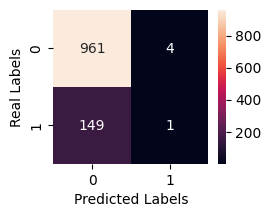

In [14]:
for model_name, model in [("Big If", big_if_classifier)]:
    
    test_preds = predict(model, x_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)

    print("Model: {}".format(model_name))
    print("\t|| Accuracy: {}% ".format(test_accuracy))
    print("\t|| Precision: {}% ".format(test_precision))
    print("\t|| Recall: {}% ".format(test_recall))
    print("\t|| F1: {}% ".format(test_f1))

    cf_train_matrix = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(2.5,2))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d')
    plt.xlabel("Predicted Labels")
    plt.ylabel("Real Labels")
    plt.show()

**Q: What are some of the shortcomings of this big-if classifier? How could you mitigate such problems?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
Money, drugs, winner can be mentioned in a non-spam context, leading to higher false positives (FP). Such spurrious correlations could be mitigated by taking into account the context in which they are being mentioned.
```

**Q: What are some other linguistic features you think that could help classify spam messages without having as many false-negatives? To check what type of linguistic features you can extract with [spacy](https://spacy.io/), take a look at [this page](https://spacy.io/usage/linguistic-features).**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
There is no right or wrong answer! This is just food for thought :)
```

## 4) SpaCy Classifier

### Loading the following classifier can take from 0.5-7 minutes depending on your internet connection, so start running this code while reading the rest of the notebook (ignore the warnings!):

In [15]:
# NOTE: Ignore the content of this code. Simply run it :)

# -) Reformatting data for spacy text categorizer
#    The few-shotness comes from the fact that we only train with 200 examples from the actual ~4000 training examples we have
train_data_dict = {
    "1": [],
    "0": []
}
for i in range(200): 
    label_str = str(y_train[i])
    train_data_dict[label_str] = train_data_dict[label_str] + [x_train[i]]

# -) Load the spacy text categorizer / few-shot learn from the reformatted examples
spacy_classifier = spacy.load("en_core_web_sm") # nlp = spacy.blank("en") 
spacy_classifier.add_pipe(
    "text_categorizer", 
    config={
        "data": train_data_dict, 
        "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "device": "cpu"
    }
)

Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

The following classifier will be a classifier trained with spacy that you will learn later on in the course. For now focus on the evaluation & some cool aspects of this package.

You may have noticed that our tokenization is too simple. "money" could be written right before a comma, and apostrophes might also create duplicate tokens that actually refer to the same word. Spacy provides a [tokenizer](https://spacy.io/usage/linguistic-features#tokenization) for different languages that takes care of such edge cases. 

And that's not only it! The framework is organized as a pipeline that takes a plain string **text** and turns it into a featurized **Doc**. Document here doesn't mean multiple sentences. You can think of **Doc** as an augmentation of the plain text into meaningful linguistic features that can be better signals for classification tasks. Here is a possible set of [components](https://spacy.io/usage/processing-pipelines) to make up the spacy *nlp* pipeline:

![NLP Pipeline](spacy-pipeline.svg)

Notice that the tokenizer is separate. This is because for a given language, spaCy has only one tokenizer. As said on the [website](https://spacy.io/usage/processing-pipelines#pipeline-components-tokenizer:~:text=The%20capabilities%20of%20a%20processing%20pipeline%20always%20depend%20on%20the%20components):
    
> [...] while all other pipeline components take a Doc and return it, the tokenizer takes a string of text and turns it into a Doc
    
So let's create an English pipeline with only the tokenizer by disabling the rest of the components.

First, we need to load the language specific **nlp** pipeline with spacy.load(). Then there are 2 ways to pass text into spacy.
1. You can process an individual string with:
    ```
    nlp(text)
    ```
2. You can process a stream of multiple strings with:
    ```
    nlp.pipe(texts)
    ```

In [16]:
sample_texts = [
    "This message is not a spam, believe me!!",
    "I AM DEFINETLY A SPAM, give me 2000$, I need money, please help!",
    "I am not a spam message, don't confuse me with it!"
]

# 1) Load the language specific NLP pipeline
nlp = spacy.load("en_core_web_sm")
print("The default English nlp pipe components are: {}. We disable them in the pipe call.\n".format(nlp.pipe_names))

# 2) Process multiple texts with the nlp.pipe function
for doc in nlp.pipe(sample_texts, disable=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']):
    print([token.text for token in doc])

The default English nlp pipe components are: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']. We disable them in the pipe call.

['This', 'message', 'is', 'not', 'a', 'spam', ',', 'believe', 'me', '!', '!']
['I', 'AM', 'DEFINETLY', 'A', 'SPAM', ',', 'give', 'me', '2000', '$', ',', 'I', 'need', 'money', ',', 'please', 'help', '!']
['I', 'am', 'not', 'a', 'spam', 'message', ',', 'do', "n't", 'confuse', 'me', 'with', 'it', '!']


In [17]:
print(spacy_classifier("I am looking for kitchen appliances.")._.cats)

{'0': 0.9993455572939021, '1': 0.0006544427060978458}


In [18]:
print(spacy_classifier("For only 1000$, you can also be a winner!")._.cats)

{'0': 0.122680177414941, '1': 0.8773198225850588}


Wow! The predicted probabilities for each label seem quite reasonable. Now let's test this on the whole test dataset:

In [22]:
def predict_spacy(model, dataset):
    preds = []
    for doc in model.pipe(dataset):
        res_dict = doc._.cats
        pred = int(max(res_dict, key=res_dict.get)) # NOTE: this is one way to argmax in python
        preds.append(pred)
    return preds

Evaluating with the spacy classifier takes longer than our models, so note that the following **may take around a minute**:

________________________________________________________________
Model: Spacy
	|| Accuracy: 0.957847533632287% 
	|| Precision: 0.8280254777070064% 
	|| Recall: 0.8666666666666667% 
	|| F1: 0.8469055374592834% 


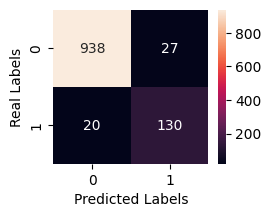

In [24]:
for model_name, model in [("Spacy", spacy_classifier)]:
    
    test_preds = predict_spacy(model, x_test)
    
    test_accuracy = accuracy_score(y_test, test_preds)
    test_precision = precision_score(y_test, test_preds)
    test_recall = recall_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds)
    cf_train_matrix = confusion_matrix(y_test, test_preds)

    print("________________________________________________________________")
    print("Model: {}".format(model_name))
    print("\t|| Accuracy: {}% ".format(test_accuracy))
    print("\t|| Precision: {}% ".format(test_precision))
    print("\t|| Recall: {}% ".format(test_recall))
    print("\t|| F1: {}% ".format(test_f1))

    plt.figure(figsize=(2.5,2))
    sns.heatmap(cf_train_matrix, annot=True, fmt='d')
    plt.xlabel("Predicted Labels")
    plt.ylabel("Real Labels")
    plt.show()

**Q: What can you notice about the precision/recall/F1/confusion matrix results? What is particularly improved compared to the "Big-If" classifier?**

*A: TODO - your answer here!*

```{toggle} Click the button to reveal the answer!
SOLUTION:
The number of false negatives (FN) wasn't too badly affected (didn't increase), but the number of false positives (FP) has drastically decreased, leading to the ideal high values in the TP-TN diagonal.
```

## 5) Statistical Significance & Comparing all Models

Now that we have many models under our belt, let's compare the statistical significance of the 4 classifiers:
- Rand Binom
- Always False
- Big If
- Spacy

As you learned it lecture, one way to measure stastical significance is by doing a k-cross validation. Once again, scikit-learn has a convenient [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class that splits a given dataset input and output into **k** folds. Here we will use **k** $=5$ which gives us a ratio of 0.2 validation set. We hold out the test set, and do this procedure only on the train set. Note that the following may take 10 minutes to run as the spacy model gets retrained with 200 examples every new k-fold.

In [25]:
k = 5 # NOTE: You can change the value of k via the argument here!
k_fold = KFold(k)
kfold_iteration = enumerate(k_fold.split(x_train, y_train))

metrics = {
    "Rand Uniform": {
        'acc': [],
        'pre': [],
        'rec': [],
    },
    "Rand Binom p={}".format(prior_p): {
        'acc': [],
        'pre': [],
        'rec': [],
    },
    "Always False": {
        'acc': [],
        'pre': [],
        'rec': [],
    },
    "Big If": {
        'acc': [],
        'pre': [],
        'rec': [],
    },
    "Spacy": {
        'acc': [],
        'pre': [],
        'rec': [],
    },
}

for k, (train_idx, val_idx) in kfold_iteration:
    print("K-cross validation iteration {}".format(k))
    x_tr, x_val = x_train[train_idx], x_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    for model_name, model in [
        ("Rand Uniform", rand_binom_uniform_classifier), 
        ("Rand Binom p={}".format(prior_p), rand_binom_biased_classifier), 
        ("Always False", always_false_classifier),
        ("Big If", big_if_classifier)]:

        val_preds = predict(model, x_val)
        metrics[model_name]['acc'].append(accuracy_score(y_val, val_preds))
        metrics[model_name]['pre'].append(precision_score(y_val, val_preds))
        metrics[model_name]['rec'].append(recall_score(y_val, val_preds))

    for model_name, model in [("Spacy", nlp)]:
        train_data_dict = {
            "1": [],
            "0": []
        }
        for i in range(200): # NOTE: you can increase the training size by making this number larger
            label_str = str(y_tr[i])
            train_data_dict[label_str] = train_data_dict[label_str] + [x_tr[i]]

        nlp = spacy.load("en_core_web_sm") # nlp = spacy.blank("en") 
        nlp.add_pipe(
            "text_categorizer", 
            config={
                "data": train_data_dict, 
                "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
                "device": "cpu"
            }
        )    
        val_preds = predict_spacy(nlp, x_val)
        metrics[model_name]['acc'].append(accuracy_score(y_val, val_preds))
        metrics[model_name]['pre'].append(precision_score(y_val, val_preds))
        metrics[model_name]['rec'].append(recall_score(y_val, val_preds))

K-cross validation iteration 0


/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

/Users/bayazit/miniconda3/envs/inlpvenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ignore MatMul due to non constant B: /[MatMul_149]
Ignore MatMul due to non constant B: /[MatMul_154]
Ignore MatMul due to non constant B: /[MatMul_243]
Ignore MatMul due to non constant B: /[MatMul_248]
Ignore MatMul due to non constant B: /[MatMul_337]
Ignore MatMul due to non constant B: /[MatMul_342]
Ignore MatMul due to non constant B: /[MatMul_431]
Ignore MatMul due to non constant B: /[MatMul_436]
Ignore MatMul due to non constant B: /[MatMul_525]
Ignore MatMul due to non constant B: /[MatMul_530]
Ignore MatMul due to non constant B: /[MatMul_619]
Ignore MatMul due to non constant B: /[MatMul_624]
Ignore MatMul due to non constant B: /[MatMul_713]
Ignore MatMul due to non constant B: /[MatMul_718]
Ignore MatMul due to non constant B: /[MatMul_807]
Ignore MatMul due to non constant B: /[MatMul_812]
Ignore MatMul due to non constant B: /[MatMul_901]
Ignore MatMul due to non constant B: /[MatMul_906]
Ignore MatMul due to non constant B: /[MatMul_995]
Ignore MatMul due to non consta

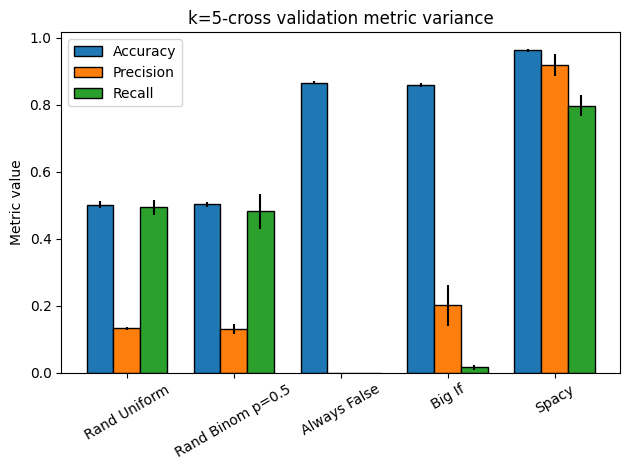

In [26]:
acc_means = []
acc_stds = []
pre_means = []
pre_stds = []
rec_means = []
rec_stds = []

model_names = list(metrics.keys())
for model in model_names:
    acc_means.append(np.mean(metrics[model]['acc']))
    acc_stds.append(np.std(metrics[model]['acc']))
    #
    pre_means.append(np.mean(metrics[model]['pre']))
    pre_stds.append(np.std(metrics[model]['pre']))
    #
    rec_means.append(np.mean(metrics[model]['rec']))
    rec_stds.append(np.std(metrics[model]['rec']))

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x, acc_means, width,  yerr=acc_stds, label='Accuracy', edgecolor = 'black')
rects1 = ax.bar(x + width , pre_means, width,  yerr=pre_stds, label='Precision', edgecolor = 'black')
rects2 = ax.bar(x + width * 2, rec_means, width,  yerr=rec_stds, label='Recall', edgecolor = 'black')

ax.set_ylabel('Metric value')
ax.set_title('k=5-cross validation metric variance')
ax.set_xticks(x + width, model_names, rotation = 30)
ax.legend()

fig.tight_layout()
plt.show()

**Q: While you may not have enough time to run these experiments during today's practical session, what difference do you think you would notice when k = 2 vs. k = 5 vs. k=10?**

*A:* TODO - answer here...

```{toggle} Click the button to reveal the answer!
SOLUTION:
k=2 divides the training & validation set into 50%, making the training set smaller and the validation set larger the 2 times it get evaluated on. This can make the variance look smaller than how it actually can be with k=5. Similarly a large enough k value could make the variance look much larger as the label distribution of the validation set can change more drastically.
```